# Ref
- Stanで統計モデリングを学ぶ(5): とりあえず階層ベイズモデルを試してみる（応用編：トレンドのあるモデル） *追記2件あり
 - https://tjo.hatenablog.com/entry/2014/05/28/190123

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
input = pd.read_csv('../input/hb_trend_sample.txt', sep=' ')

In [3]:
input.columns

Index(['x1', 'x2', 'x3', 'y'], dtype='object')

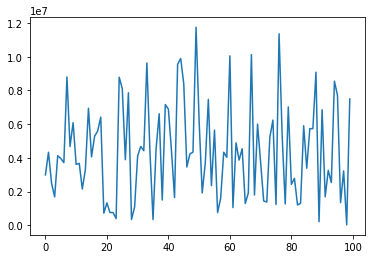

In [4]:
#plt.plot(input['y'])
plt.plot(input['x1'])
plt.show()

In [5]:
y = input['y']
y[:5]

0    2387
1    2625
2    2371
3    2351
4    2684
Name: y, dtype: int64

In [6]:
X = input[['x1','x2','x3']]
X.head()

,x1,x2,x3
0,2988021,3029541,3429375
1,4331957,2996819,4128007
2,2492737,3027725,4200477
3,1683820,2957989,6376299
4,4128840,2858124,6004612


In [7]:
lr = LinearRegression()
lr.fit(X, y)  # x needs to be 2d for LinearRegression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

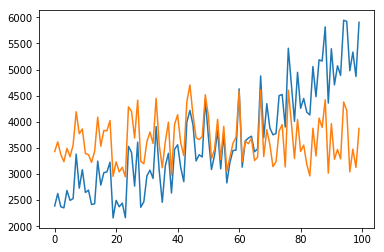

In [8]:
plt.plot(input['y'])
plt.plot(lr.predict(X))
plt.show()

In [9]:
input.head()

,x1,x2,x3,y
0,2988021,3029541,3429375,2387
1,4331957,2996819,4128007,2625
2,2492737,3027725,4200477,2371
3,1683820,2957989,6376299,2351
4,4128840,2858124,6004612,2684


In [10]:
input.shape

(100, 4)

In [77]:
import pystan

model = """
data {
    int<lower=0> N;
    real<lower=0> x1[N];
    real<lower=0> x2[N];
    real<lower=0> x3[N];
    real<lower=0> y[N];
}

parameters {
    real trend[N];
    real s_trend;
    real s_q;
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real d;
}

model {
    real q[N];
    real cum_trend[N];
    trend~normal(30,10);
    for (i in 3:N)
        trend[i]~normal(2*trend[i-1]-trend[i-2],s_trend);

    cum_trend[1]<-trend[1];
    for (i in 2:N)
        cum_trend[i]<-cum_trend[i-1] + trend[i];

for (i in 1:N)
        q[i]<-y[i]-cum_trend[i];
    for (i in 1:N)
        q[i]~normal(a*x1[i]+b*x2[i]+c*x3[i]+d,s_q);
}
"""

dat = {
    'N': 100,
    'x1': input['x1'],
    'x2': input['x2'],
    'x3': input['x3'],
    'y' : input['y']
}
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_878b55a338cf957790a8aff904849766 NOW.


In [78]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_878b55a338cf957790a8aff904849766.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
trend[1]   12.25    0.12   3.04   6.27  10.16  12.29  14.29  17.99    638   1.02
trend[2]   10.72    0.05   1.21   8.37    9.9  10.75  11.51  12.99    635   1.02
trend[3]   10.02    0.02   0.76   8.54    9.5  10.02  10.56   11.5   1917    1.0
trend[4]    9.76    0.02   0.73   8.35   9.27   9.75  10.25  11.25   1471    1.0
trend[5]    9.81    0.02   0.71    8.4   9.33   9.81  10.29  11.19   1089    1.0
trend[6]    9.98    0.02   0.73   8.48   9.51   9.96  10.45  11.46    952    1.0
trend[7]    9.99    0.02   0.69   8.61   9.52   10.0  10.45  11.37    882   1.01
trend[8]    9.95    0.02   0.71   8.57   9.49   9.93  10.42  11.35    815    1.0
trend[9]   10.09    0.03    0.7    8.7   9.6

In [79]:
fit.extract()

OrderedDict([('trend',
              array([[ 13.21176313,  10.20981004,   8.42410443, ...,  50.78687908,
                       51.10351444,  49.55724046],
                     [  6.99241764,  10.01759734,  10.27904067, ...,  49.19713839,
                       51.57263866,  49.05138037],
                     [ 12.52203116,   9.52555186,  10.05801507, ...,  50.82870479,
                       50.46761009,  49.26891588],
                     ..., 
                     [  8.70975121,  10.31540637,  10.23278791, ...,  50.55822576,
                       49.82909248,  50.26993231],
                     [ 13.31342078,  11.13599227,  10.98502847, ...,  50.44679696,
                       49.90799317,  49.60408287],
                     [  8.43371153,   9.97224337,   9.14813038, ...,  49.78092261,
                       51.8414129 ,  50.25785927]])),
             ('s_trend',
              array([ 2.16707053,  2.61210462,  2.34130602, ...,  1.48593354,
                      2.21252685,  1.812

In [80]:
dens_a = fit.extract()['a']
dens_b = fit.extract()['b']
dens_c = fit.extract()['c']
dens_d = fit.extract()['d']

In [81]:
fit.extract()['trend'].shape

(2000, 100)

In [82]:
a_est = dens_a.mean()
b_est = dens_b.mean()
c_est = dens_c.mean()
d_est = dens_d.mean()
print([a_est, b_est, c_est, d_est])

[0.00014997653584666537, 0.00024887620216434324, 5.0099360478738835e-05, 1000.1369286195652]


In [84]:
trend_est = []
for i in range(100):
    tmp = fit.extract()['trend'][:, i]
    trend_est.append(tmp.mean())

In [85]:
pred = a_est*input['x1']+b_est*input['x2']+c_est*input['x3']+d_est+np.cumsum(trend_est)

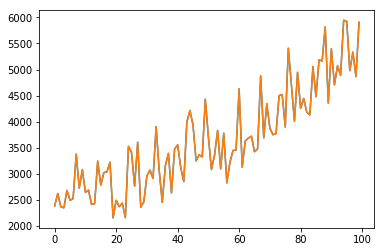

In [88]:
plt.plot(input['y'])
plt.plot(pred)
plt.show()

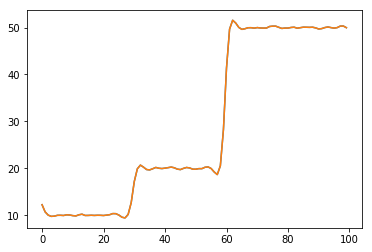

In [91]:
plt.plot(trend_est)
plt.show()